In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np

from weights import RidgeRegressor, Diffusion
from ranking import BasicFasSolver, IlpSolver, AC, IL, SP, DF
from dataloader import Synthesizer
from ranking.fassolver.embedding import get_sym_embs

In [2]:
%matplotlib inline
np.random.seed(0)
# plt.rcParams['text.usetex'] = True
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times"

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [3]:
m = 4
n_test = 200

n_train = 80
corruption = .65
skewed = True

corruption = .5
n_train = 50
skewed = False

datagen = Synthesizer('RK-' + str(m))
ind_map = datagen.loader.ind_map

x_train, (y_train, y_sc_tr) = datagen.get_trainset(n_train, verbose=True)
x_test, (y_test, y_score) = datagen.get_testset(n_test, verbose=True)

S_train = datagen.synthetic_corruption(y_train, corruption, skewed=skewed, y_score=y_sc_tr)

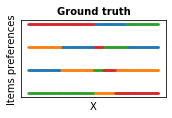

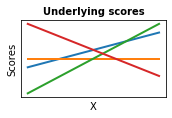

In [4]:
def show_setting(x, y, y_score, ind_map):
    fig1, ax1 = plt.subplots(1, 1, figsize=(2.5, 1.75))
    fig2, ax2 = plt.subplots(1, 1, figsize=(2.5, 1.75))
    y = get_sym_embs(y, ind_map).sum(axis=-1).argsort()
    for i in range(y.shape[1]):
        ax1.scatter(x, (y == i).argmax(axis=1), s=2)
        ax2.plot(x, y_score[i], linewidth=2)
    ax1.set_title('Ground truth', size=10, fontweight='bold')
    ax1.set_ylabel('Items preferences', size=10)
    ax2.set_title('Underlying scores', size=10, fontweight='bold')
    ax2.set_ylabel('Scores', size=10)
    for ax in [ax1, ax2]:
        ax.set_xlabel(r"X", size=10)
        ax.tick_params(axis='both', 
                       which='major', 
                       bottom=False,
                       top=False,
                       right=False,
                       left=False,
                       labelbottom=False,
                       labelleft=False)
    for fig in [fig1, fig2]:
        fig.tight_layout()
        
    fig1.savefig('savings/rk/setting_1.pdf')
    fig2.savefig('savings/rk/setting_2.pdf')
    return fig1

fig1 = show_setting(x_test, y_test, y_score, ind_map)
fig1.savefig('savings/rk/setting.pdf')
# fig2.savefig('savings/rk/scores.pdf')

### Show training data with corruption

In [5]:
def get_observed(S_train, ind_map):
    m = len(ind_map)
    observed = np.zeros((S_train.shape[0], m), dtype=np.int)
    for j in range(m):
        for i in range(j):
            seen = S_train[:, ind_map[i, j]] != 0
            observed[:, i] += seen
            observed[:, j] += seen
    return observed

observed = get_observed(S_train, ind_map)

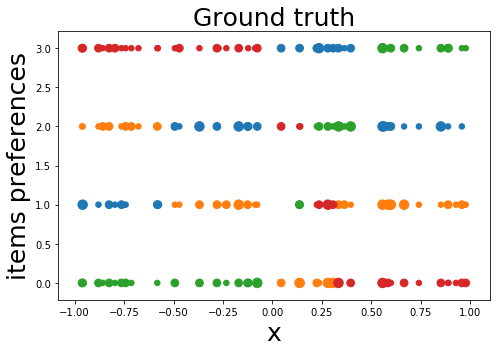

In [6]:
def show_training_set(x, y, S, ind_map):
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Get observed
    m = len(ind_map)
    observed = np.zeros((S_train.shape[0], m), dtype=np.int)
    for j in range(m):
        for i in range(j):
            seen = S_train[:, ind_map[i, j]] != 0
            observed[:, i] += seen
            observed[:, j] += seen

    # Plot figure accordingly
    y = get_sym_embs(y, ind_map).sum(axis=-1).argsort()
    for i in range(y.shape[1]):
        ind = observed[:, i].astype(np.bool_)
        ax.scatter(x[ind], (y == i).argmax(axis=1)[ind], s=30*observed[:, i][ind])
    ax.set_title('Ground truth', size=25)
    ax.set_ylabel('items preferences', size=25)
    ax.set_xlabel("x", size=25)
    fig.tight_layout()
    return fig

show_training_set(x_train, y_train, S_train, ind_map).savefig('savings/rk/training.pdf')

In [7]:
kernel_type = 'Gaussian'
# kernel_type = 'Laplacian'
sigmas = [5e-1, 3e-1, 2e-1, 1e-1]
sigmas = [1]
lambdas = [1e-3 / np.sqrt(50)]

# sigmas = [1e-1]
# lambdas = [1e3, 1, 1e-3, 1e-6]

In [8]:
kernel_reg = RidgeRegressor('Gaussian', sigma=1)
kernel_reg.set_support(x_train[:, np.newaxis])

solver = IlpSolver(ind_map)
solver.choose_solver_method('primal')
solver.shut_up()
# solver = BasicFasSolver(ind_map)

msolver = IlpSolver(ind_map)
msolver.choose_solver_method('dual')
msolver.shut_up()

met_ac = AC(kernel_reg, msolver)
met_il = IL(kernel_reg, msolver)
met_sp = SP(kernel_reg, msolver)
met_df = DF(kernel_reg, msolver)

In [9]:
best_err_df, best_err_il = 2 * (np.inf,)

for sigma in sigmas:
    kernel_reg.update_sigma(sigma)
    for lambd in lambdas:
        kernel_reg.update_lambda(lambd)

        met_ac.train(x_train[:, np.newaxis], S_train, lambd=lambd)        
        met_il.train(x_train[:, np.newaxis], S_train, lambd=lambd)
        met_sp.train(x_train[:, np.newaxis], S_train, lambd=lambd)

        y_ac = met_ac(x_test[:, np.newaxis], verbose=False)        
        y_il = met_il(x_test[:, np.newaxis], verbose=False)
#         y_sp = met_sp(x_test[:, np.newaxis], verbose=False)
        
        print('.', end='')
        


.

In [10]:
y_sp = y_ac

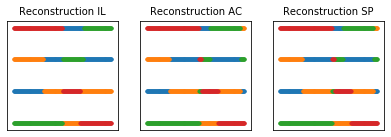

In [11]:
def show_reconstruction(x, y_1, y_2, y_test, ind_map):
    m = len(ind_map)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6.75, 2))

    s_1 = get_sym_embs(y_1, ind_map).sum(axis=1).argsort()[:,::-1]
    s_2 = get_sym_embs(y_2, ind_map).sum(axis=1).argsort()[:,::-1]
    s_t = get_sym_embs(y_test, ind_map).sum(axis=1).argsort()[:,::-1]
    for i in range(m):
        ax1.scatter(x, (s_1==i).argmax(axis=1), s=10)
        ax2.scatter(x, (s_2==i).argmax(axis=1), s=10)
        ax3.scatter(x, (s_t==i).argmax(axis=1), s=10)

    ax1.set_title("Reconstruction IL", size=10)
    ax2.set_title("Reconstruction AC", size=10)
    ax3.set_title("Reconstruction SP", size=10)
    
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='both', 
                       which='major', 
                       bottom=False,
                       top=False,
                       right=False,
                       left=False,
                       labelbottom=False,
                       labelleft=False)
    return fig


show_reconstruction(x_test, y_il, y_ac, y_sp, ind_map).savefig('savings/rk/reconstruction.pdf')

In [12]:
show_reconstruction(x_train, best_dis, y_train, y_train, ind_map);

NameError: name 'best_dis' is not defined

## Varying corruption

In [13]:
np.random.seed(0)

In [14]:
m = 10
skewed = True

nb_folds = 4
# corruptions = [.5, .6, .7, .8, .9, 1]
corruptions = np.linspace(.5, 1, num=10)
sigmas = [1e-1, 5e-2, 1e-2]
lambdas = [1e6, 1e3, 1e0, 1e-3, 1e-6]
sigmas = [1, 5e-1]
lambdas = [1e3, 1e0, 1e-3]

n_train = 80
n_train = 20
n_test = 50

kernel_type = "Gaussian"

In [15]:
datagen = Synthesizer('RK-' + str(m))
ind_map = datagen.loader.ind_map

kernel_reg = RidgeRegressor(kernel_type, sigma=1)

solver = IlpSolver(ind_map)
solver.choose_solver_method('primal')
solver.shut_up()

msolver = IlpSolver(ind_map)
msolver.choose_solver_method('dual')
msolver.shut_up()

met_ac = AC(kernel_reg, msolver)
met_il = IL(kernel_reg, msolver)
met_df = DF(kernel_reg, msolver)

In [19]:
shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))

err_ac = -np.ones(shape_err)
err_il = -np.ones(shape_err)
err_df = -np.ones(shape_err)

x_test, (y_test, y_score) = datagen.get_testset(n_test, verbose=True)
for fold in range(nb_folds):
    x_train, (y_train, y_sc_tr) = datagen.get_trainset(n_train, verbose=True)
    kernel_reg.set_support(x_train[:, np.newaxis])
    n_train, dim = x_train[:, np.newaxis].shape    

    for i_s, c_sigma in enumerate(sigmas):
        sigma = c_sigma * dim
        kernel_reg.update_sigma(sigma)

        for i_l, c_lambda in enumerate(lambdas):
            lambd = c_lambda / np.sqrt(n_train)
            kernel_reg.update_lambda(lambd)
            alpha_train = kernel_reg(x_train[:, np.newaxis])
            alpha_train += alpha_train.T
            # Stabilize CPLEX
            alpha_train /= alpha_train.max()
            alpha_train *= 1e5

            for i_c, corruption in enumerate(corruptions):
                S_train = datagen.synthetic_corruption(y_train, corruption, skewed=skewed, y_score=y_sc_tr)                

                y_df = DF.disambiguation(alpha_train, S_train, 1e-3, solver)
                met_df.computer.set_phi(y_df)
                y_df = met_df(x_test[:, np.newaxis], verbose=False)        

                met_il.phi_init = S_train.astype(np.float)
                met_il.const = met_il.phi_init
                y_il = met_il(x_test[:, np.newaxis], verbose=False)

                phi = AC.get_center(S_train, 1, msolver)
                met_ac.computer.set_phi(phi)
                y_ac = met_ac(x_test[:, np.newaxis], verbose=False)
            
                err_df[i_c, fold, i_s, i_l] = ((2*(y_df > 0) - 1) != y_test).mean()
                err_il[i_c, fold, i_s, i_l] = ((2*(y_il > 0) - 1) != y_test).mean()
                err_ac[i_c, fold, i_s, i_l] = ((2*(y_ac > 0) - 1) != y_test).mean()
                print((corruption * 10) // 1, end=',')
    print()

5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,
5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,
5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,
5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,9.0,10.0,


In [21]:
mus = np.empty((3, len(corruptions)))
stds = np.empty((3, len(corruptions)))
best_lambdas = np.empty((3, len(corruptions)))
best_sigmas = np.empty((3, len(corruptions)))

for err, i in zip([err_df, err_il, err_ac], [0, 1, 2]):
    tmp = err.reshape(err.shape[0], err.shape[1], -1)
    mu = tmp.mean(axis=1)
    std = tmp.std(axis=1)
    ind = mu.argmin(axis=-1)
    for j in range(len(ind)):
        mus[i, j] = mu[j, ind[j]]
        stds[i, j] = std[j, ind[j]]
        best_lambdas[i, j] = lambdas[ind[j] % len(lambdas)]
        best_sigmas[i, j] = sigmas[ind[j] // len(lambdas)]

In [22]:
best_lambdas, best_sigmas

(array([[1.e-03, 1.e-03, 1.e-03, 1.e-03, 1.e+00, 1.e-03, 1.e+03, 1.e+00,
         1.e+03, 1.e+03],
        [1.e-03, 1.e-03, 1.e-03, 1.e-03, 1.e+00, 1.e+03, 1.e+03, 1.e+03,
         1.e+03, 1.e+03],
        [1.e-03, 1.e-03, 1.e-03, 1.e-03, 1.e+00, 1.e-03, 1.e+03, 1.e+00,
         1.e+03, 1.e+03]]),
 array([[0.5, 0.5, 0.5, 1. , 0.5, 1. , 0.5, 1. , 0.5, 0.5],
        [0.5, 0.5, 0.5, 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 1. , 0.5, 1. , 0.5, 1. , 0.5, 0.5]]))

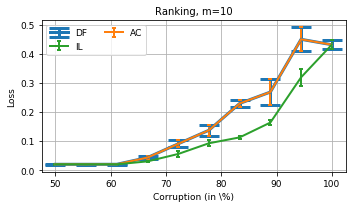

In [29]:
fig, ax = plt.subplots(figsize=(5, 3))
# mus[2][-1] = .5
# mus[1][-1] = .48
a = ax.errorbar([100*i for i in corruptions[:]], mus[0][:], .5*stds[0][:], capsize=10, linewidth=3, capthick=3)
c = ax.errorbar([100*i for i in corruptions[:]], mus[2][:], .5*stds[2][:], capsize=2, linewidth=2, capthick=2)
b = ax.errorbar([100*i for i in corruptions[:]], mus[1][:], .5*stds[1][:], capsize=2, linewidth=2, capthick=2)
ax.legend([a, b, c], ['DF', 'IL', "AC"], prop={'size':9}, ncol=2)
ax.grid()
ax.set_title('Ranking, m=%d' %m, size=10)
ax.set_ylabel('Loss', size=9)
ax.set_xlabel('Corruption (in \%)', size=9)
ax.tick_params(axis='both', which='major', labelsize=9)
fig.tight_layout()
fig.savefig('savings/rk/corruption.pdf')

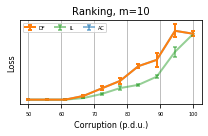

In [28]:
fig, ax = plt.subplots(figsize=(3, 2))
# stds[0][-1] = stds[2][-1]
c = ax.errorbar([100*i for i in corruptions[:]], mus[2][:], .5*stds[2][:], capsize=2, linewidth=2, capthick=2, color='C0', alpha=.5)
b = ax.errorbar([100*i for i in corruptions[:]], mus[1][:], .5*stds[1][:], capsize=2, linewidth=2, capthick=2, color='C2', alpha=.5)
a = ax.errorbar([100*i for i in corruptions[:]], mus[0][:], .5*stds[0][:], capsize=2, linewidth=2, capthick=2, color='C1')
ax.legend([a, b, c], ['DF', 'IL', "AC"], prop={'size':5}, ncol=3, loc='upper left')
ax.grid()
ax.set_title(r'Ranking, m=%d' %m, size=10)
ax.set_ylabel(r'Loss', size=8)
ax.set_yticks([])
ax.set_xlabel(r'Corruption (p.d.u.)', size=8)
ax.tick_params(axis='both', which='major', labelsize=5)
plt.tight_layout()
fig.savefig('savings/rk/corruption.pdf')#, facecolor='k', transparent=False)

In [25]:
best_sigmas, best_lambdas

(array([[0.5, 0.5, 0.5, 1. , 0.5, 1. , 0.5, 1. , 0.5, 0.5],
        [0.5, 0.5, 0.5, 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 1. , 0.5, 1. , 0.5, 1. , 0.5, 0.5]]),
 array([[1.e-03, 1.e-03, 1.e-03, 1.e-03, 1.e+00, 1.e-03, 1.e+03, 1.e+00,
         1.e+03, 1.e+03],
        [1.e-03, 1.e-03, 1.e-03, 1.e-03, 1.e+00, 1.e+03, 1.e+03, 1.e+03,
         1.e+03, 1.e+03],
        [1.e-03, 1.e-03, 1.e-03, 1.e-03, 1.e+00, 1.e-03, 1.e+03, 1.e+00,
         1.e+03, 1.e+03]]))